In [386]:
## UST-ETRI ICT Master's Course 맹준규, Toy Project ##

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [366]:
# Data from https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min
# ref notebook : https://www.kaggle.com/xiyuewang/lol-how-to-win
dataset_path = './dataset/lol_rank/high_diamond_ranked_10min.csv'

df = pd.read_csv(dataset_path, sep=',')

In [367]:
'''
데이터 설명
이 데이터는 다이아몬드 상위권~마스터 티어의 랭크게임 약 1만 판에서 딱 10분일 때 기록된 데이터입니다
attributes --> 10분에 기록된 미니언, 골드, 킬, 데스 등
target class --> 블루팀 승리or패배(블루팀승리->레드팀패배, 블루팀패배->레드팀승리)

칼럼 설명
blueWins : 블루팀 승리 여부(target class)

blueWard : 블루팀이 설치한 와드 갯수
blueWardDestroyed : 블루팀와드가 파괴된 횟수
blueFirstBlood : 블루팀이 퍼스트블러드를 기록
blueKills : 블루팀이 총 거둔 킬 수
blueDeaths : 블루팀 총 데스 수
blueAssists : 블루팀 총 어시스트 수
blueEliteMonsters : 에픽몬스터(용, 전령) 잡은 횟수
blueDragons : 블루팀이 잡은 드래곤 수
blueHeralds : 블루팀이 잡은 협곡의 전령 수
blueTowersDestroyed : 블루팀의 파괴된 타워 수
blueTotalGold : 블루팀의 총 얻은 골드
blueAvgLevel : 블루팀 레벨 평균
blueTotalExperiance : 블루팀이 획득한 총 경험치
blueTotalMinonsKilled : 블루팀이 처치한 미니언 수
blueTotalJungleMinonsKilled : 블루팀이 처치한 정글 몹 수
blueGoldDiff : 블루팀 기준, 레드팀과의 골드 차이
blueExperianceDiff : 블루팀 기준, 레드팀과 경험치 차이
blueCSPerMin : 블루팀 분 당 미니언
blueGoldPerMin : 블루팀 분 당 획득골드

타겟 클래스인 blueWins를 제외한 나머지 칼럼이
레드팀의 경우도 존재합니다. (ex:redWard, readWardDestroyed etc...)
'''

df.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


In [368]:
# Data Analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [403]:
'''
Data Cleaning
칼럼에서 아예 의미가 없거나, 중복되거나, 상응하는 의미를 가진 데이터를 제거합니다.
이는 학습에 방해가 될 수 있기 때문입니다. 한번 골라볼까요
gameId --> 게임번호는 승패와 아예 상관 없어보입니다
redFirstBlood --> 퍼블을 딴 팀이 1을 갖는 칼럼인데, 블루팀이 퍼블을 따면 레드팀은 당연히 0이겠죠?
redKills, redDeaths --> 블루팀 킬 == 레드팀 데스, 블루팀 데스 == 레드팀 킬, 서로 상응하므로 제거대상, 단 assists는 다를 수 있으므로 남김
diff시리즈 --> ~Total~시리즈를 비교해서 얻을 수 있는 자료이기 때문에 반복되므로 삭제
~CSPerMin, GoldPerMin --> 정확히 10분일 때 얻은 결과이기 때문에 TotalGold or TotalMinoinKilled로 얻을 수 있는 자료이므로 삭제
~TotalExperience --> 게임 내에서 경험치보다는 레벨이 더 중요(경험치 총량으로는 레벨이 몇인지 가늠이 안됨)하기때문에 삭제

참고한 자료에는 드래곤, 전령도 반복되는 자료기때문에삭제한다고 하였는데, 둘다 용이나 전령을 못먹는 경우가 있으므로 살려둡니다
'''
del_columns = ['gameId', 'redFirstBlood', 'redKills', 'redDeaths', 'blueGoldDiff', 'blueExperienceDiff', 'redGoldDiff', 'redExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin',
              'redCSPerMin', 'redGoldPerMin', 'blueTotalExperience', 'redTotalExperience']

#df_clean = df.drop(del_columns, axis=1)
df_clean = df.copy()
df_clean

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,4527873286,1,17,2,1,7,4,5,1,1,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,4527797466,1,54,0,0,6,4,8,1,1,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,4527713716,0,23,1,0,6,7,5,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,4527628313,0,14,4,1,2,3,3,1,1,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


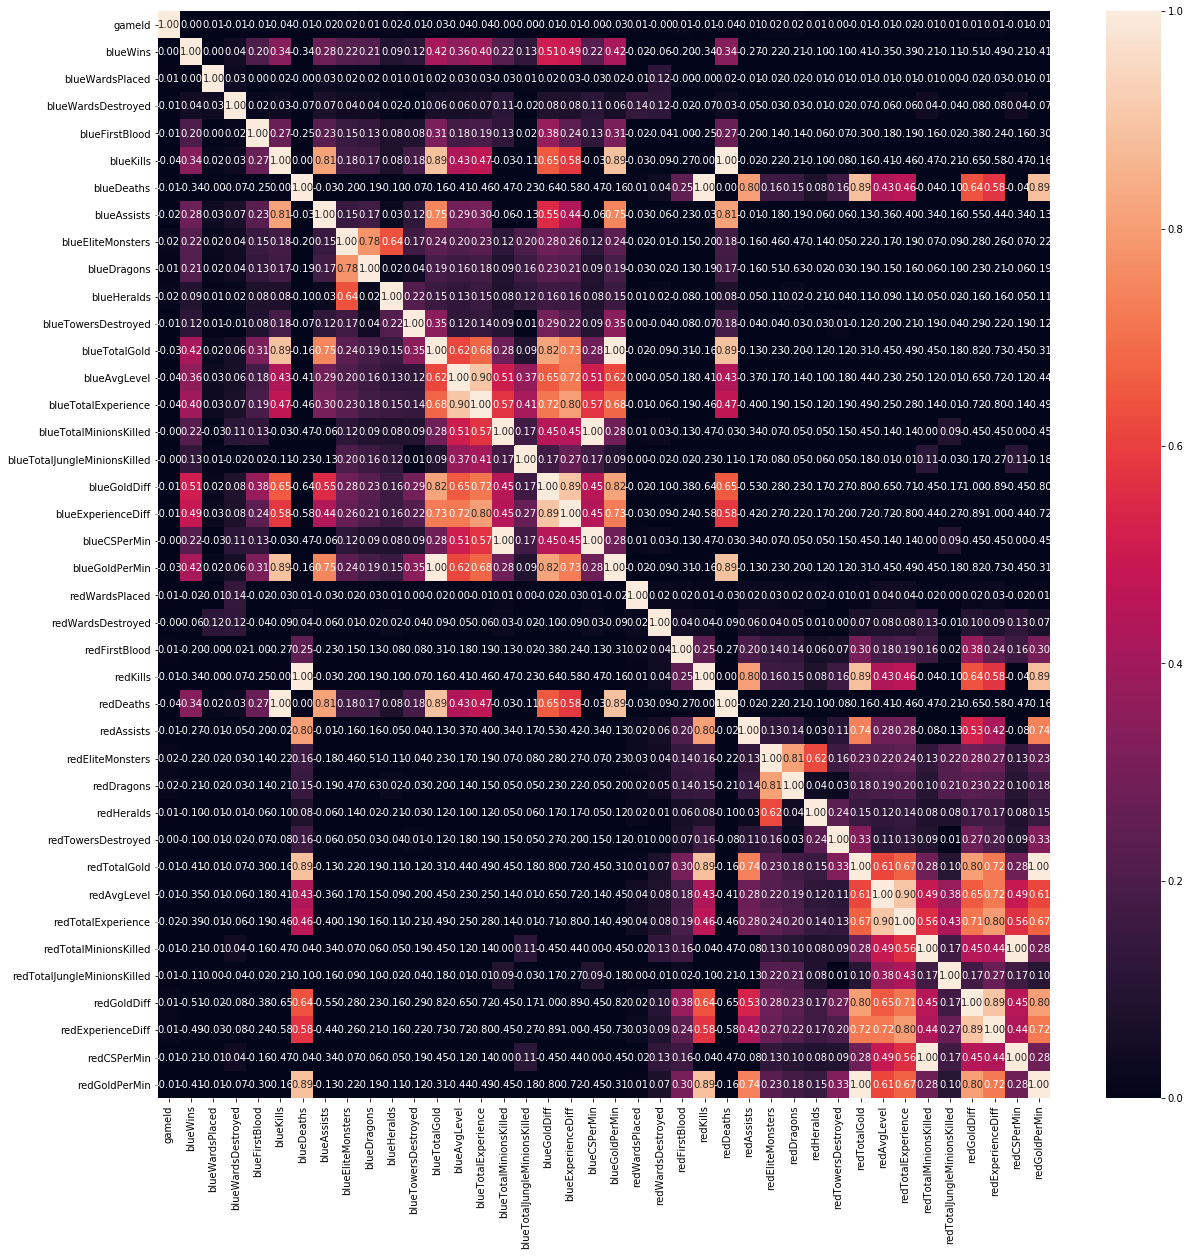

In [404]:
'''
블루팀 승리와 가장 연관이 있는 지표를 확인해봅시다.
correlation > 0 --> 양의 연관(블루팀이 이기는 것과 연관)
correlation < 0 --> 음의 연관(레드팀이 이기는 것과 연관)
correlation = 0 --> 관련 없음
'''
plt.figure(figsize=(20, 20))
sns.heatmap(df_clean.corr(), fmt='.2f', annot=True, vmin=0)

In [405]:
'''
승리와 연관이 있는 칼럼 중 correlation > 0.2 (20%) 인 것만 추려보자
'''
corr = df_clean.corr()['blueWins'] >= 0.1
del_corr_list = list(corr[corr==False].keys())

df_clean = df_clean.drop(del_corr_list, axis=1)
#df_clean = df_clean.drop(['blueFirstBlood', 'blueEliteMonsters', 'blueDragons'], axis=1)
df_clean = df_clean.drop(['redDeaths', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalGold', 'blueDragons', 'blueAssists'], axis=1)
df_clean

,blueWins,blueFirstBlood,blueKills,blueEliteMonsters,blueTowersDestroyed,blueAvgLevel,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,0,1,9,0,0,6.6,36,643,-8,19.5,1721.0
1,0,0,5,0,0,6.6,43,-2908,-1173,17.4,1471.2
2,0,0,7,1,0,6.4,46,-1172,-1033,18.6,1611.3
3,0,0,4,1,0,7.0,55,-1321,-7,20.1,1515.7
4,0,0,6,0,0,7.0,57,-1004,230,21.0,1640.0
...,...,...,...,...,...,...,...,...,...,...,...
9874,1,1,7,1,0,7.2,69,2519,2469,21.1,1776.5
9875,1,0,6,1,0,7.2,48,782,888,23.3,1623.8
9876,0,0,6,0,0,7.0,45,-2416,-1877,21.0,1590.3
9877,0,1,2,1,0,6.6,48,-839,-1085,22.4,1445.9


In [406]:
X = df_clean.drop('blueWins', axis=1)
y = df_clean['blueWins']

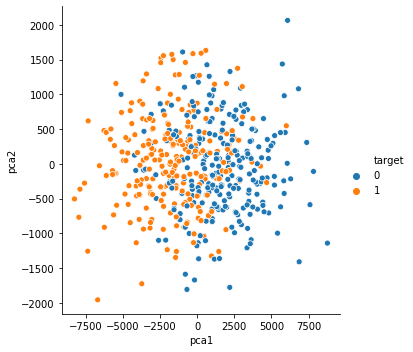

In [407]:
# PCA 분석
pca = PCA(n_components=2) # 2차원으로 축소
pca_rlt = pca.fit_transform(X[:500])
pca_rlt = pd.DataFrame(pca_rlt, columns=['pca1', 'pca2'])
pca_rlt['target'] = list(y[:500])

sns.relplot(x='pca1', y='pca2', hue='target', data=pca_rlt)

# 역전승하는 경우가 많아서그런가?

In [408]:
# Data Normalize
x_col = list(X.columns)
mms = MinMaxScaler()
#mms = StandardScaler()
stdval = mms.fit_transform(X)
stdval = pd.DataFrame(stdval, columns=x_col)
stdval

,blueFirstBlood,blueKills,blueEliteMonsters,blueTowersDestroyed,blueAvgLevel,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,1.0,0.409091,0.0,0.0,0.588235,0.391304,0.514554,0.527402,0.544041,0.499576
1,0.0,0.227273,0.0,0.0,0.588235,0.467391,0.355294,0.461512,0.435233,0.306993
2,0.0,0.318182,0.5,0.0,0.529412,0.500000,0.433152,0.469430,0.497409,0.415003
3,0.0,0.181818,0.5,0.0,0.705882,0.597826,0.426470,0.527459,0.575130,0.341300
4,0.0,0.272727,0.0,0.0,0.705882,0.619565,0.440687,0.540863,0.621762,0.437129
...,...,...,...,...,...,...,...,...,...,...
9874,1.0,0.318182,0.5,0.0,0.764706,0.750000,0.598690,0.667496,0.626943,0.542364
9875,0.0,0.272727,0.5,0.0,0.764706,0.521739,0.520788,0.578078,0.740933,0.424640
9876,0.0,0.272727,0.0,0.0,0.705882,0.489130,0.377360,0.421696,0.621762,0.398813
9877,1.0,0.090909,0.5,0.0,0.588235,0.521739,0.448087,0.466489,0.694301,0.287487


In [409]:
# modeling
class LoLWinPredModel(nn.Module):
    def __init__(self):
        super(LoLWinPredModel, self).__init__()
        
        self.fc1 = nn.Linear(10, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.pred = nn.Linear(8, 2)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, feature):
        x = F.relu(self.fc1(feature))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        pred = self.pred(x)
        
        return pred

In [410]:
# split train test

train_X, test_X, train_y, test_y = train_test_split(stdval, y, test_size=0.2)
print('Total number of Train data : ', len(train_X))
print('Total number of Test data : ', len(test_X))

Total number of Train data :  7903
Total number of Test data :  1976


In [411]:
# data prepare  data(numpy) --> data(tensor)
train_X = torch.from_numpy(np.array(train_X)).float()
train_y = torch.from_numpy(np.array(train_y)).long()

test_X = torch.from_numpy(np.array(test_X)).float()
test_y = torch.from_numpy(np.array(test_y)).long()

train = TensorDataset(train_X, train_y)
test = TensorDataset(test_X, test_y)

train_loader = DataLoader(train, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=True)

In [414]:
model = LoLWinPredModel()
loss_F = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.003)
model.train()

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(50):
    train_total_loss = 0
    train_acc = 0
    test_total_loss = 0
    test_acc = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        output = model(x)
        #print(output[0], y[0])
        
        loss = loss_F(output, y)
        argmax, pred = torch.max(output, 1)
        #print(pred[0], y[0])
        loss.backward()
        optimizer.step()
        train_total_loss += loss.data
        train_acc += (pred==y).sum().item()
    train_acc = train_acc / len(train_X)
    
    for x, y in test_loader:
        with torch.no_grad():
            output = model(x)
            loss = loss_F(output, y)
            _, pred = torch.max(output.data, 1)
            test_total_loss += loss.data
            test_acc += (pred==y).sum().item()
    test_acc = test_acc / len(test_X)
        
    
    print('''Epoch {}
    Train ----> Loss : {}    Accuracy : {}
    Test  ----> Loss : {}    Accuracy : {}'''.format(epoch+1, train_total_loss, train_acc, test_total_loss, test_acc))
    
    train_losses.append(train_total_loss)
    train_accs.append(train_acc)
    test_losses.append(test_total_loss)
    test_accs.append(test_acc)
    
    

Epoch 1
    Train ----> Loss : 19.9449462890625    Accuracy : 0.6325446033151968
    Test  ----> Loss : 4.883744239807129    Accuracy : 0.6695344129554656
Epoch 2
    Train ----> Loss : 18.79144859313965    Accuracy : 0.6740478299379983
    Test  ----> Loss : 4.750248432159424    Accuracy : 0.6847165991902834
Epoch 3
    Train ----> Loss : 18.206735610961914    Accuracy : 0.6929014298367708
    Test  ----> Loss : 4.714165210723877    Accuracy : 0.694331983805668
Epoch 4
    Train ----> Loss : 17.999958038330078    Accuracy : 0.6931544982917879
    Test  ----> Loss : 4.714598655700684    Accuracy : 0.6958502024291497
Epoch 5
    Train ----> Loss : 17.788166046142578    Accuracy : 0.6966974566620271
    Test  ----> Loss : 4.551696300506592    Accuracy : 0.7059716599190283
Epoch 6
    Train ----> Loss : 17.544376373291016    Accuracy : 0.713526508920663
    Test  ----> Loss : 4.603533744812012    Accuracy : 0.7019230769230769
Epoch 7
    Train ----> Loss : 17.555023193359375    Accuracy :

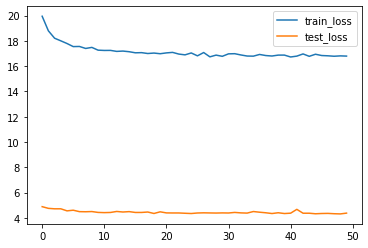

In [417]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_loss', 'test_loss'])
plt.show()

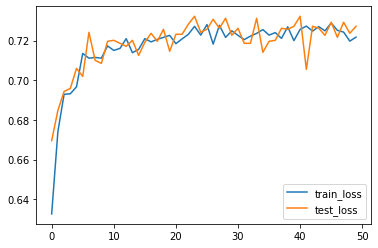

In [418]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_loss', 'test_loss'])
plt.show()

In [419]:
test_accsmax(test_accs)

0.7322874493927125